C:\Users\cutea\AppData\Local\Temp\ipykernel_90152\2370341426.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\cutea\AppData\Local\Temp\ipykernel_90152\2370341426.py:23: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Best trial:
  Value (Accuracy): 0.8244
  Params: 
    max_depth: 8
    learning_rate: 0.010293679852541898
    subsample: 0.5861714809537368
    n_estimators: 110

Test Accuracy: 0.7989
Test F1 Score: 0.7231
Test AUC: 0.7747


C:\Users\cutea\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[10:19:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




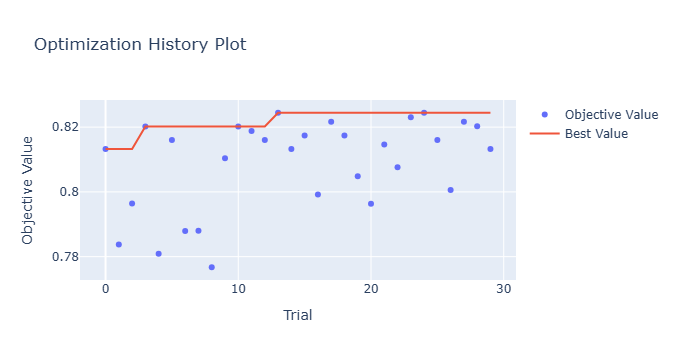

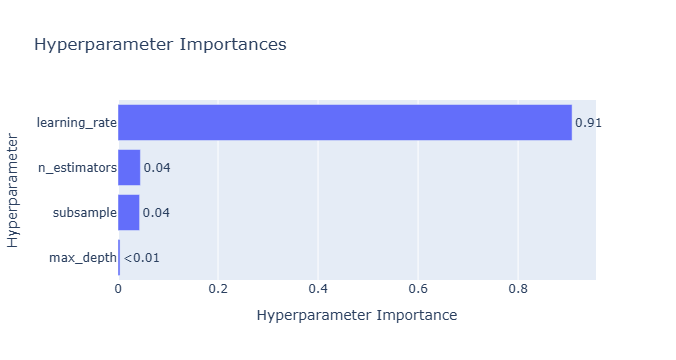

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [2]:
# ---------------------------
# 1. 라이브러리 불러오기
# ---------------------------
import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from xgboost import XGBClassifier

# ---------------------------
# 2. 데이터 불러오기 및 전처리
# ---------------------------
# scikit-learn에서 예제 데이터 대신 Kaggle Titanic 데이터를 사용
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# 간단한 전처리
df["Age"].fillna(df["Age"].median(), inplace=True)
df["Embarked"].fillna("S", inplace=True)

# Label Encoding (Sex, Embarked)
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])
df["Embarked"] = le.fit_transform(df["Embarked"])

# Feature & Target 정의
X = df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
y = df["Survived"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Optuna Objective 함수
# ---------------------------
def objective(trial):
    # 탐색할 파라미터 정의
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "use_label_encoder": False,
        "eval_metric": "logloss",
    }
    
    # 모델 정의
    model = XGBClassifier(**param)
    
    # 교차검증으로 성능 평가
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    accuracy = scores.mean()
    
    return accuracy

# ---------------------------
# 4. Study 생성 및 최적화
# ---------------------------
study = optuna.create_study(direction="maximize")  # Accuracy를 최대화
study.optimize(objective, n_trials=30)

# ---------------------------
# 5. 최적 파라미터 확인
# ---------------------------
print("Best trial:")
trial = study.best_trial
print("  Value (Accuracy): {:.4f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# ---------------------------
# 6. 최적 파라미터로 최종 모델 학습 및 평가
# ---------------------------
best_params = trial.params
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Accuracy, F1, AUC 계산
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("\nTest Accuracy: {:.4f}".format(accuracy))
print("Test F1 Score: {:.4f}".format(f1))
print("Test AUC: {:.4f}".format(auc))

# ---------------------------
# 7. 성능 변화 시각화
# ---------------------------
import optuna.visualization as vis

# 최적화 히스토리
fig1 = vis.plot_optimization_history(study)
fig1.show()

# 파라미터 중요도
fig2 = vis.plot_param_importances(study)
fig2.show()

# 필요하면 이미지 저장
fig1.write_image("optimization_history.png")
fig2.write_image("param_importances.png")
